In [ ]:
from google.colab import files
files.upload()

In [3]:
!ls -lha kaggle.json

!pip install -q Kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list -s image

-rw-r--r-- 1 root root 66 May 19 20:21 kaggle.json
ref                                               title                                      size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------  ----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
tarundalal/dangerous-insects-dataset              Dangerous Farm Insects Dataset            447MB  2023-06-25 05:52:52           1753         45  0.875            
muratkokludataset/pistachio-image-dataset         Pistachio Image Dataset                    27MB  2022-03-28 18:01:27           6221       1605  0.9375           
muratkokludataset/rice-image-dataset              Rice Image Dataset                        219MB  2022-04-03 02:12:00          18481       1813  0.875            
vishalsubbiah/pokemon-images-and-types            Pokemon Image Dataset                       4MB  2024-03-14 18:23:40          3

In [ ]:
!kaggle datasets download -d msambare/fer2013

!unzip fer2013.zip

In [12]:
import os
import matplotlib.pyplot as plt

In [6]:
os.listdir("train")

['sad', 'happy', 'neutral', 'fear', 'surprise', 'angry', 'disgust']

In [7]:
os.listdir("test")

['sad', 'happy', 'neutral', 'fear', 'surprise', 'angry', 'disgust']

In [8]:
TRAIN_DATA = 'train'
TEST_DATA = 'test'

In [28]:
angry = os.listdir(os.path.join(TRAIN_DATA,'angry'))
fear = os.listdir(os.path.join(TRAIN_DATA,'fear'))
sad = os.listdir(os.path.join(TRAIN_DATA,'sad'))
happy = os.listdir(os.path.join(TRAIN_DATA,'happy'))
surprise = os.listdir(os.path.join(TRAIN_DATA,'surprise'))
neutral = os.listdir(os.path.join(TRAIN_DATA,'neutral'))
disgust = os.listdir(os.path.join(TRAIN_DATA,'disgust'))

Text(0.5, 1.0, 'Training Data Image Distribution')

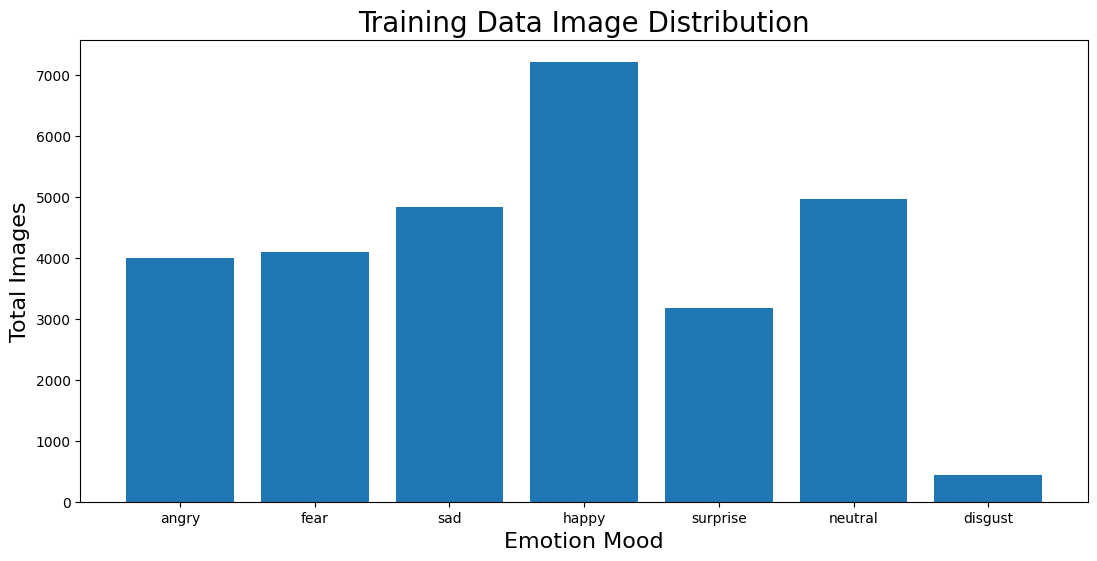

In [29]:
plt.figure(figsize=(13,6))
plt.bar(
    ['angry','fear','sad','happy','surprise','neutral','disgust'],
    [len(angry),len(fear),len(sad),len(happy),len(surprise),len(neutral),len(disgust)]
)
plt.xlabel("Emotion Mood",fontsize=16)
plt.ylabel("Total Images",fontsize=16)
plt.title("Training Data Image Distribution",fontsize=20)

In [30]:
len(angry)+len(fear)+len(sad)+len(happy)+len(surprise)+len(neutral)+len(disgust)

28709

In [45]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from tensorflow.keras import layers, Model

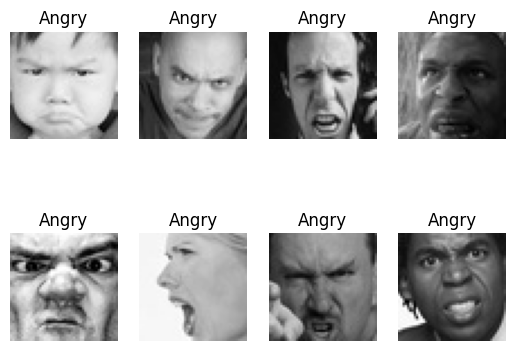

In [32]:
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(load_img(os.path.join(TRAIN_DATA,'angry',angry[i])))
    plt.axis("off")
    plt.title("Angry")

In [34]:
x = load_img(os.path.join(TRAIN_DATA,'angry',angry[0]))
x = keras.utils.img_to_array(x)
x.shape

(48, 48, 3)

## Preprocessing

In [38]:
train_aug = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_aug = ImageDataGenerator(rescale=1./255)

In [39]:
training_data = train_aug.flow_from_directory(TRAIN_DATA,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                class_mode='categorical')


testing_data = test_aug.flow_from_directory(TEST_DATA,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [40]:
for image,label in training_data:
    print(image.shape)
    print(label.shape)
    break

(64, 48, 48, 3)
(64, 7)


In [41]:
vggmodel = keras.applications.VGG16(include_top=False,weights='imagenet',classes=7,input_shape=(48,48,3))

58889256/58889256 [==============================] - 3s 0us/step


In [44]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [42]:
set_trainable = False
for layer in vggmodel.layers:
    if layer.name == 'block5_conv1':
        print("In")
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In


In [46]:
x = layers.Flatten()(vggmodel.output)
hidden = layers.Dense(512,activation='relu')(x)
output = layers.Dense(7,activation='softmax')(hidden)
model = Model(vggmodel.input,output)

In [48]:
model.compile(loss='categorical_crossentropy',
                 optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                 metrics=['acc'])

In [58]:
history = model.fit_generator(
    training_data,
    steps_per_epoch=100,
    epochs=3,
    validation_data=testing_data
  )

<ipython-input-58-552560729016>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
100/100 [==============================] - 467s 5s/step - loss: 1.7054 - acc: 0.3186 - val_loss: 1.6662 - val_acc: 0.3339
Epoch 2/3
100/100 [==============================] - 405s 4s/step - loss: 1.6566 - acc: 0.3419 - val_loss: 1.6433 - val_acc: 0.3505
Epoch 3/3
100/100 [==============================] - 408s 4s/step - loss: 1.6506 - acc: 0.3534 - val_loss: 1.6205 - val_acc: 0.3651


In [61]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

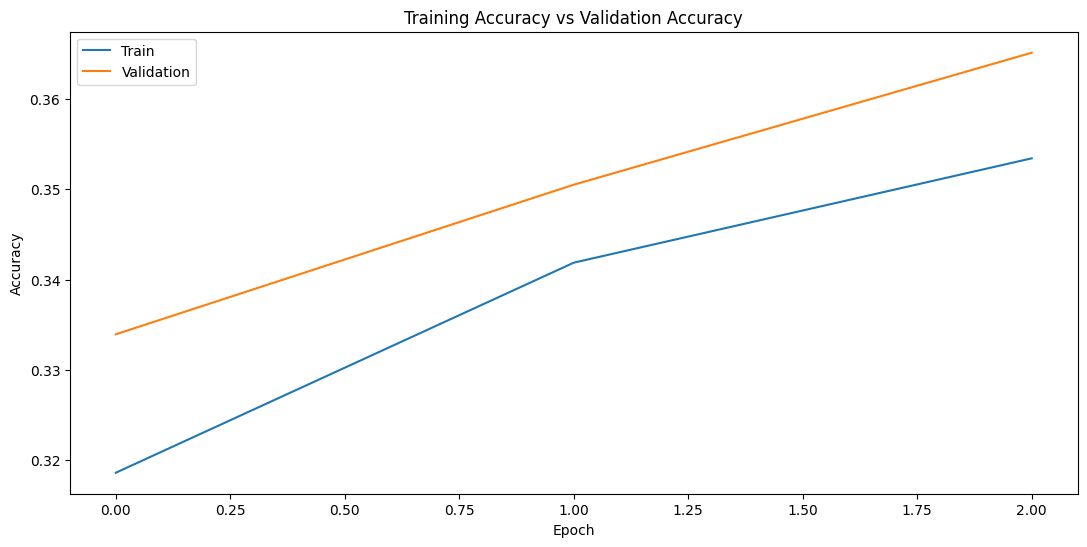

In [62]:
plt.figure(figsize=(13,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [59]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

In [60]:
y_pred = model.predict(testing_data)
y_pred = np.argmax(y_pred, axis=1)
class_labels = testing_data.class_indices
class_labels = {v:k for k,v in class_labels.items()}

113/113 [==============================] - 177s 2s/step


In [63]:
from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(testing_data.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')

Confusion Matrix
[[   1    0   18  625  144   75   95]
 [   0    0    2   78   10    7   14]
 [   5    0   34  668  142   72  103]
 [  10    0   47 1141  245  124  207]
 [   2    0   31  800  174   95  131]
 [   1    0   31  778  198  105  134]
 [   2    0   34  531  106   69   89]]
Classification Report


In [65]:
training_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [66]:
target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

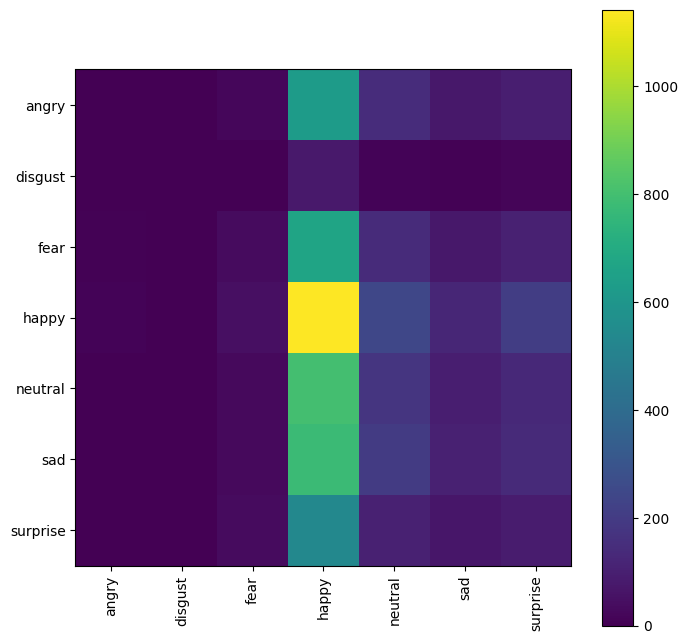

In [67]:
plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)